## Expected Residential System Size Function

This notebook formalizes an **expected residential system size** under the controlled
conditions established in Notebook 02.

The purpose of this notebook is to transform observed, admissible baseline behavior
into a **reference expectation** that can be consumed downstream.

This notebook does **not**:
- explain system size behavior
- predict future installations
- reinterpret admissibility decisions

It formalizes expectation only.


## Controlled Inputs

All computations in this notebook operate exclusively on a canonical baseline artifact
produced at the end of Notebook 02.

That artifact already enforces:

- residential installations only
- temporal validity
- admissible installation years (1999–2023)
- admissible residential system size domain (0–40 kW DC)

No excluded records are reintroduced.
No constraints are re-evaluated.


In [20]:
import pandas as pd
from pathlib import Path

# Repo-root canonical directory (notebook lives in /notebooks)
canonical_dir = Path("..") / "outputs" / "canonical"
baseline_path = canonical_dir / "baseline_residential_system_sizes.csv"

baseline_df = pd.read_csv(baseline_path)

baseline_df.head(), baseline_df.shape


(   installation_year  pv_system_size_dc
 0             1999.0           3.274033
 1             2017.0           5.700000
 2             1999.0           6.272357
 3             2017.0           8.260000
 4             1999.0           3.480814,
 (1854757, 2))

## Expected Size Definition

We now compute an **expected residential system size** for each installation year.

Expectation here is defined as:
- the **median** system size
- computed within each admissible installation year
- based only on the canonical baseline universe

The median is used because:
- it reflects central tendency
- it is robust to upper-tail skew
- it preserves the descriptive stability established in Notebook 02


In [21]:
expected_size_by_year = (
    baseline_df
    .groupby("installation_year")["pv_system_size_dc"]
    .median()
    .reset_index(name="expected_system_size_kw")
)

expected_size_by_year


,installation_year,expected_system_size_kw
0,1999.0,2.748600
1,2000.0,2.706744
2,2001.0,2.843784
3,2002.0,3.000000
4,2003.0,3.080000
5,2004.0,3.169300
6,2005.0,3.675000
7,2006.0,4.200000
8,2007.0,4.320000
9,2008.0,4.140000


## Attaching Expectation to Observations

Having validated the expected residential system size by installation year,
the next step is to **attach this expectation back to each baseline observation**.

This does not introduce new assumptions.

The purpose of this step is to:
- align each observed system size with its year-specific expected value
- prepare the data for deviation (residual) analysis

At this stage:
- no residuals are computed
- no interpretation is made
- no records are filtered or reweighted

This is a structural alignment step only.


In [23]:
baseline_with_expectation = baseline_df.merge(
    expected_size_by_year,
    on="installation_year",
    how="left"
)

baseline_with_expectation.head()

,installation_year,pv_system_size_dc,expected_system_size_kw
0,1999.0,3.274033,2.7486
1,2017.0,5.700000,5.8000
2,1999.0,6.272357,2.7486
3,2017.0,8.260000,5.8000
4,1999.0,3.480814,2.7486


In [ ]:
baseline_with_expectation.shape
baseline_with_expectation.isna().sum()

installation_year          0
pv_system_size_dc          0
expected_system_size_kw    0
dtype: int64

## Defining Deviation From Expected Size

With the expected residential system size attached to each observation,
we can now define **deviation from reference behavior**.

Deviation (or residual) is defined as:

    observed system size − expected system size (year-specific)

This quantity measures **how individual installations differ from
the stable descriptive baseline** established in Notebook 02 and formalized here.

At this stage:
- residuals are computed mechanically
- no interpretation is applied
- no thresholds are imposed

In [25]:
baseline_with_expectation["size_residual_kw"] = (
    baseline_with_expectation["pv_system_size_dc"]
    - baseline_with_expectation["expected_system_size_kw"]
)

baseline_with_expectation[
    ["installation_year", "pv_system_size_dc", "expected_system_size_kw", "size_residual_kw"]
].head()

,installation_year,pv_system_size_dc,expected_system_size_kw,size_residual_kw
0,1999.0,3.274033,2.7486,0.525433
1,2017.0,5.700000,5.8000,-0.100000
2,1999.0,6.272357,2.7486,3.523757
3,2017.0,8.260000,5.8000,2.460000
4,1999.0,3.480814,2.7486,0.732214


## Inspecting Residual Distributions

Residuals quantify how individual residential installations deviate from the expected system size for their installation year.

Inspecting the residual distribution serves three purposes:

1. Verify that deviations are centered reasonably around zero
2. Understand the spread and skew of residential size variation
3. Detect structural asymmetries or heavy tails that may matter downstream

This step is **diagnostic only**:
- no filtering is applied
- no thresholds are imposed
- no interpretation is finalized


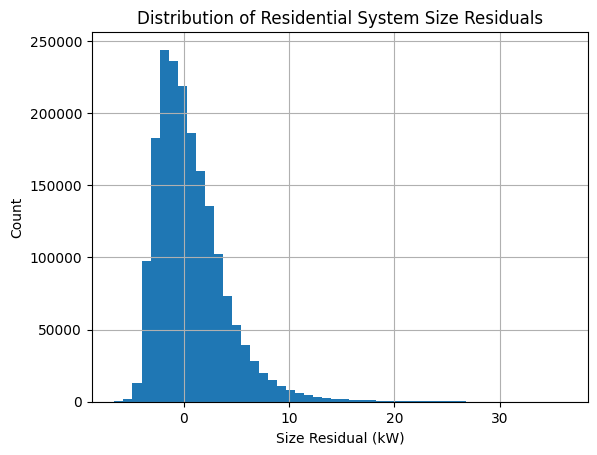

In [26]:
import matplotlib.pyplot as plt

plt.figure()
baseline_with_expectation["size_residual_kw"].hist(bins=50)
plt.xlabel("Size Residual (kW)")
plt.ylabel("Count")
plt.title("Distribution of Residential System Size Residuals")
plt.show()


## Residuals by Installation Year

The overall residual distribution confirms that deviations are mostly centered near zero, with a right-skewed tail reflecting larger-than-typical installations.

However, aggregate distributions can mask **time-specific structure**.

Inspecting residuals by installation year allows us to verify:

- whether dispersion is relatively stable across time
- whether certain years exhibit asymmetric or unusually wide residuals
- whether later years show systematically larger positive deviations

This step is diagnostic only.
No filtering or correction is applied.

<Figure size 1400x600 with 0 Axes>

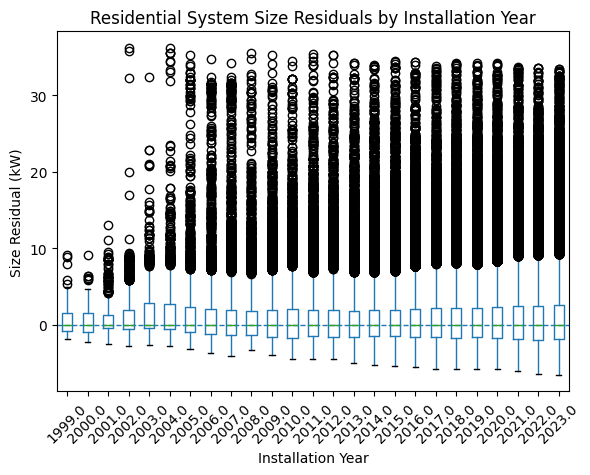

In [27]:
plt.figure(figsize=(14, 6))

baseline_with_expectation.boxplot(
    column="size_residual_kw",
    by="installation_year",
    grid=False,
    rot=45
)

plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Installation Year")
plt.ylabel("Size Residual (kW)")
plt.title("Residential System Size Residuals by Installation Year")
plt.suptitle("")  # suppress pandas default title
plt.show()


## Inference From Residual Distributions

Inspection of residual distributions—both in aggregate and by installation year—
supports the validity of the expected size reference derived in this notebook.

From the residual histogram:
- deviations are centered near zero
- the distribution is right-skewed, reflecting larger-than-typical residential systems
- no secondary modes or pathological structure are observed

From the year-by-year residual boxplots:
- median residuals remain consistently near zero across all admissible years
- dispersion is broadly stable through time, with gradual widening in later years
- large positive residuals appear in all years and do not concentrate in isolated periods

These patterns indicate that:
- the expected size values are well aligned with observed behavior
- deviations reflect legitimate heterogeneity, not baseline mis-specification
- no additional conditioning is required to stabilize the reference behavior

Residual inspection therefore **confirms**, rather than challenges, the baseline
and expectation definitions established earlier.


## Expected Size Function Definition

Based on the validated baseline and confirmed residual behavior, the expected
residential system size is defined as a discrete empirical function:

    f(y) = expected residential system size in installation year y

Where:
- the domain of y is the set of admissible installation years {1999, …, 2023}
- f(y) is defined as the median residential system size observed in year y
- the function is undefined outside the admissible domain

This function is:
- empirical rather than parametric
- descriptive rather than predictive
- piecewise by construction

It constitutes the expected size function referenced in the project structure
and is intended for downstream analytical use.


In [28]:
# Expected size function as an explicit mapping
expected_size_function = dict(
    zip(
        expected_size_by_year["installation_year"],
        expected_size_by_year["expected_system_size_kw"]
    )
)

# Example lookup (illustrative)
expected_size_function[2015]

5.46

## Canonical Outputs

This notebook produces the following canonical artifacts:

1. **Expected system size by installation year**
   - a discrete empirical expected size function
2. **Baseline residential system sizes with expected values and residuals**
   - a residualized reference dataset for downstream analysis

These outputs:
- encode all baseline and expectation decisions
- are descriptive and non-predictive
- may be consumed without reinterpreting upstream notebooks


In [29]:
canonical_dir = Path("..") / "outputs" / "canonical"
canonical_dir.mkdir(parents=True, exist_ok=True)

expected_size_by_year.to_csv(
    canonical_dir / "expected_system_size_by_year.csv",
    index=False
)

baseline_with_expectation.to_csv(
    canonical_dir / "baseline_with_expected_size.csv",
    index=False
)

print("Canonical outputs written to:")
print("- expected_system_size_by_year.csv")
print("- baseline_with_expected_size.csv")


Canonical outputs written to:
- expected_system_size_by_year.csv
- baseline_with_expected_size.csv
